In [1]:
import numpy as np
import pandas as pd

from flagger import BayesFlaggerBeta
from flagger_tools import BayesFlaggerBetaTest
from flagger_tools import get_sampler_data
from matplotlib import pyplot as plt

<string>:11: SyntaxWarning: invalid escape sequence '\s'
<string>:193: SyntaxWarning: invalid escape sequence '\s'


### Real World Data

Create sampler from data

In [2]:
r = 0.2
P0 = pd.read_csv("Data/sample_reference_group.csv")
P1 = pd.read_csv("Data/sample_critical_group.csv")
sampler = get_sampler_data(r, P0, P1)

Administration parameters

In [3]:
K = 20   # Number of reviews per admin
M = 3    # Length of feature vector
N = 100  # Number of test takers per admin
T = 100  # Number of admins (time horizon)

Initialize flaggers with different selection policies

In [4]:
bayes_flagger_pol_1 = BayesFlaggerBeta(K, M, rule="detection")
bayes_flagger_pol_2 = BayesFlaggerBeta(K, M, rule="information")
bayes_flagger_pol_3 = BayesFlaggerBeta(K, M, rule="mixed")

Initialize testing classes

In [5]:
bayes_test_pol_1 = BayesFlaggerBetaTest(bayes_flagger_pol_1, sampler, N)
bayes_test_pol_2 = BayesFlaggerBetaTest(bayes_flagger_pol_2, sampler, N)
bayes_test_pol_3 = BayesFlaggerBetaTest(bayes_flagger_pol_3, sampler, N)

Number of simulated rollouts

In [6]:
rollouts = 20

Simulate detection-greedy policy

In [7]:
total_pol_1 = np.zeros((rollouts, T + 1))
detected_pol_1 = np.zeros((rollouts, T + 1))
model_pol_1 = []

for n in range(rollouts):
    total_pol_1[n], detected_pol_1[n], model, _ = bayes_test_pol_1.run(T)
    model_pol_1.append(model)

Fixed-point iteration did not converge, using last iterate.


Simulate information-greedy policy

In [8]:
total_pol_2 = np.zeros((rollouts, T + 1))
detected_pol_2 = np.zeros((rollouts, T + 1))
model_pol_2 = []

for n in range(rollouts):
    total_pol_2[n], detected_pol_2[n], model, _ = bayes_test_pol_2.run(T)
    model_pol_2.append(model)

Simulate mixed policy

In [9]:
total_pol_3 = np.zeros((rollouts, T + 1))
detected_pol_3 = np.zeros((rollouts, T + 1))
phi_pol_3 = np.zeros((rollouts, T + 1))
model_pol_3 = []

for n in range(rollouts):
    total_pol_3[n], detected_pol_3[n], model, phi_pol_3[n] = bayes_test_pol_3.run(T)
    model_pol_3.append(model)

Plot average detection rates

In [10]:
rate_1 = np.mean(detected_pol_1[:, 1:] / total_pol_1[:, 1:], axis=0)
rate_2 = np.mean(detected_pol_2[:, 1:] / total_pol_2[:, 1:], axis=0)
rate_3 = np.mean(detected_pol_3[:, 1:] / total_pol_3[:, 1:], axis=0)

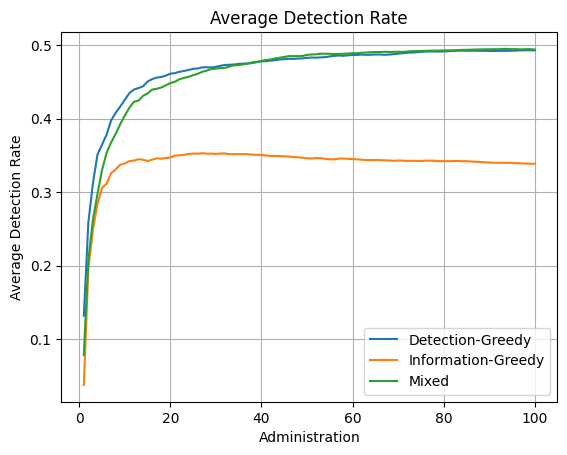

In [11]:
plt.plot(range(1, T+1), rate_1, label="Detection-Greedy")
plt.plot(range(1, T+1), rate_2, label="Information-Greedy")
plt.plot(range(1, T+1), rate_3, label="Mixed")
plt.title("Average Detection Rate")
plt.ylabel("Average Detection Rate")
plt.xlabel("Administration")
plt.legend()
plt.grid()

Plot posterior means of $R$

In [12]:
# MSE of R in dB
r_est_pol_1 = np.zeros((rollouts, T + 1))
r_est_pol_2 = np.zeros((rollouts, T + 1))
r_est_pol_3 = np.zeros((rollouts, T + 1))

for n in range(rollouts):
    r_est_pol_1[n] = np.array([model.v[1] / model.v.sum() for model in model_pol_1[n]])
    r_est_pol_2[n] = np.array([model.v[1] / model.v.sum() for model in model_pol_2[n]])
    r_est_pol_3[n] = np.array([model.v[1] / model.v.sum() for model in model_pol_3[n]])

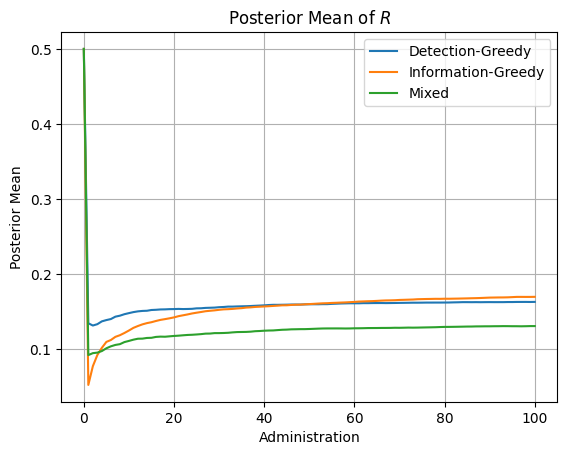

In [13]:
plt.plot(range(T+1), np.mean(r_est_pol_1, axis=0), label="Detection-Greedy")
plt.plot(range(T+1), np.mean(r_est_pol_2, axis=0), label="Information-Greedy")
plt.plot(range(T+1), np.mean(r_est_pol_3, axis=0), label="Mixed")
plt.title(r"Posterior Mean of $R$")
plt.ylabel("Posterior Mean")
plt.xlabel("Administration")
plt.legend()
plt.grid()